In [2]:
import numpy as np
import pandas as pd

## The raw data files have been concatenated into a single csv file

In [6]:
df = pd.read_csv('data/processed/LoanStats-combined.csv')
print df.shape

/Users/stephane/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(887382, 111)


In [7]:
print list(df.columns)


['lc_id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open

In [8]:

df.head(1)

,lc_id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


## Try to find categorical features, & verify data types

Categorical features are most likely string types with a handful of unique values. Try to identify those here:

In [26]:
num_unique_items = [ df[x].unique().shape[0] for x in df]
print 'numvalues, index, type, name'
for x in sorted(zip(num_unique_items,range(len(df.columns)),[type(df[x][0]) for x in df.columns],df.columns)):
    print x

numvalues, index, type, name
(1, 51, <type 'numpy.int64'>, 'policy_code')
(2, 5, <type 'str'>, 'term')
(2, 17, <type 'str'>, 'pymnt_plan')
(2, 35, <type 'str'>, 'initial_list_status')
(2, 52, <type 'str'>, 'application_type')
(3, 14, <type 'str'>, 'verification_status')
(4, 55, <type 'float'>, 'verification_status_joint')
(6, 12, <type 'str'>, 'home_ownership')
(6, 99, <type 'numpy.float64'>, 'num_tl_120dpd_2m')
(6, 100, <type 'numpy.float64'>, 'num_tl_30dpd')
(7, 8, <type 'str'>, 'grade')
(9, 16, <type 'str'>, 'loan_status')
(9, 56, <type 'numpy.float64'>, 'acc_now_delinq')
(11, 78, <type 'numpy.float64'>, 'chargeoff_within_12_mths')
(12, 11, <type 'str'>, 'emp_length')
(13, 49, <type 'numpy.float64'>, 'collections_12_mths_ex_med')
(13, 61, <type 'numpy.float64'>, 'open_il_12m')
(13, 105, <type 'numpy.float64'>, 'pub_rec_bankruptcies')
(14, 20, <type 'str'>, 'purpose')
(14, 59, <type 'numpy.float64'>, 'open_acc_6m')
(18, 62, <type 'numpy.float64'>, 'open_il_24m')
(19, 66, <type 'numpy

## Categoricals probably have fewer unique values, look for those (they will also have at least 2 different values, otherwise they're not a variable). Also list the actual values.

In [36]:
nuis = [ df.columns[i] for i, x in enumerate(num_unique_items) if (x < 20) & (x > 1)]
for x in nuis:
    print "'{}'".format(x)
    print df[x].value_counts()
    print

'term'
 36 months    621127
 60 months    266255
Name: term, dtype: int64

'grade'
B    254535
C    245860
A    148203
D    139543
E     70705
F     23047
G      5489
Name: grade, dtype: int64

'emp_length'
10+ years    291570
2 years       78870
< 1 year      70606
3 years       70026
1 year        57095
5 years       55704
4 years       52529
n/a           44825
7 years       44595
8 years       43955
6 years       42950
9 years       34657
Name: emp_length, dtype: int64

'home_ownership'
MORTGAGE    443558
RENT        356118
OWN          87471
OTHER          182
NONE            50
ANY              3
Name: home_ownership, dtype: int64

'verification_status'
Source Verified    329559
Verified           291071
Not Verified       266752
Name: verification_status, dtype: int64

'loan_status'
Current                                                573404
Fully Paid                                             238357
Charged Off                                             53599
Late (31-120 

## There are several obvious categoricals based on the above list

### These first two I will treat as ordinal, since it seems there is a logical ordering of their values:
- `'term'` - the length of the loan, treating it as an ordinal
- `'emp_length'` - can also be treated as an ordinal, I think

### Lending Club loan grade:
- `'grade'` - this I'll eventually treat as a response, based on previous analysis. It's already a ranking of the probability that the loan will be paid back.

### And the categoricals:
- ```
'home_ownership', 'verification_status', 'pymnt_plan','purpose','initial_list_status','application_type','verification_status_joint'
                    ```
                    
### The remaining variables in the short list all have numeric values, so I'm going to leave them that way.

## Process the categoricals:

In [52]:
cat_feature_names = ['home_ownership', 'verification_status', 
                     'pymnt_plan','purpose','initial_list_status',
                    'application_type','verification_status_joint']

df_catf = pd.get_dummies(df[cat_feature_names])
df=pd.concat([df,df_catf],axis = 1)
print df.shape

(887382, 154)


## Process the ordinals:

In [48]:
ord_feature_names = ['term', 'emp_length']
ord_feature_numnames = [x + '_num' for x in ord_feature_names]
ord_feature_map = [
    ['term', {' 36 months' :0, ' 60 months' : 1}], 
    ['emp_length', {'< 1 year': .5, '1 year' : 1, '2 years' : 2, '3 years' : 3, '4 years':4, '5 years':5, 
                   '6 years':6, '7 years':7, '8 years':8, '9 years':9, '10+ years':10,
                   'n/a': 0 }]
]

In [50]:
#minidf = df.head(30) # for testing dummies & categorical conversions
for x in ord_feature_map:
    df[x[0]+'_num']=df[x[0]].map(x[1])
#print df.head()
print df[ord_feature_names].head()
print df[ord_feature_numnames].head()

         term emp_length
0   36 months  10+ years
1   60 months   < 1 year
2   36 months  10+ years
3   36 months  10+ years
4   60 months     1 year
   term_num  emp_length_num
0         0            10.0
1         1             0.5
2         0            10.0
3         0            10.0
4         1             1.0


In [256]:
print df.shape

(10000, 156)


## Convert the response variable to a binary representation

`'loan_status'` Is what I eventually want to predict. It has many possible values, but the majority of them can be simplified to either a 'successful' loan or a 'default' loan

In [55]:
df.loan_status.value_counts()

Current                                                573404
Fully Paid                                             238357
Charged Off                                             53599
Late (31-120 days)                                      11339
In Grace Period                                          5346
Late (16-30 days)                                        2297
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Default                                                   291
Name: loan_status, dtype: int64

In [259]:
df['loan_status_num'] = df.loan_status.map(
    {'Charged Off':0, 'Default':0, 'Fully Paid':1, 'Current':1})
tot_good_loans = df.loan_status_num[df.loan_status_num == 1].count()
total_success_rate = float(tot_good_loans)/df.loan_status_num.count()
print "overall success rate for loans({}/{}):  {}% ".format(
    tot_good_loans, df.loan_status_num.count(), total_success_rate)

overall success rate for loans(9164/9751):  0.939801046047% 


## Modify 'grade'

I can use this for comparison and/or verification during parts of the analysis

In [185]:
df.grade.value_counts().sort_index()

A    1662
B    2907
C    2748
D    1576
E     797
F     239
G      71
Name: grade, dtype: int64

In [69]:
df['grade_num'] = df.grade.map({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6})
gradenames=sorted(df.grade.unique())
gradenums = np.arange(0,7)


## Finally, create a list of features for fitting a model

As a first pass, I'm only pulling out numeric features. Text processing can be added later.

In [260]:
num_cols=list(df._get_numeric_data().columns) # I spent an unnecessary amount of time figuring out how to do this, and it turns out there's  a builtin for it...
# remove cols we won't use for model fitting
rem_cols = ['lc_id', 'member_id', 'loan_status_num', 'grade_num']
for r in rem_cols:
    num_cols.remove(r)
#print num_cols
print len(num_cols)

127


## After all that, finally ready to try to fit something?

In [73]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics


### Initially, downsample the DataFrame for quicker testing

In [261]:
df=df.sample(n=10000)
df.sort_values(by='grade_num',inplace=True)
print df.shape

### NaNs are a problem, so one more filtering step:

In [262]:
validindexlist=(df.loan_status_num ==1) | (df.loan_status_num == 0)
#X = df[num_cols][validindexlist].fillna(0)
#X = pd.DataFrame(df['grade_num'][validindexlist].fillna(0)) # just grade num, like before
#X = pd.DataFrame(df[(list(['grade_num'])+num_cols)[0:10]][validindexlist].fillna(0)) # new vals + grade_num
X = pd.DataFrame(df[num_cols[0:10]][validindexlist].fillna(0)) # just a few new features

y = df.loan_status_num[validindexlist].fillna(0)
print type(X) ,X.shape
print type(y), y.shape
print 'done'

<class 'pandas.core.frame.DataFrame'> (9751, 10)
<class 'pandas.core.series.Series'> (9751,)
done


### Now train, test, split

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=22)
logreg2 = LogisticRegression()
logreg2.fit(X_train,y_train)
y_pred_class = logreg2.predict(X_test)
y_pred_prob = logreg2.predict_proba(X_test)
print "percent of loans successful in y_test: {}/{} = {}".format(y_test[y_test == 1].count(), y_test.count(),
                                                       float(y_test[y_test == 1].count())/ y_test.count() )
print "percent of loans predicted to be successful: {}/{} = {}".format(y_pred_class.sum() , len(y_pred_class),
                                                        float(y_pred_class.sum())/len(y_pred_class))
                                                                 
a = [i for i,x in enumerate(y_pred_class) if x != 1]
print len(a), a
print logreg2.classes_
print y_pred_prob[a]
print y_pred_prob[0:3]

print 'done'

percent of loans successful in y_test: 2302/2438 = 0.94421657096
percent of loans predicted to be successful: 2436.0/2438 = 0.999179655455
2 [5, 1179]
[ 0.  1.]
[[ 0.90680921  0.09319079]
 [ 0.58128398  0.41871602]]
[[ 0.01731309  0.98268691]
 [ 0.11585646  0.88414354]
 [ 0.06494855  0.93505145]]
done


### (this will be a good spot for a confusion matrix)

### To check results of the fit, plot the predicted probabilities

This was a first attempt to view a correlation between the predicted probabilities and the outcomes of the loans. I hoped to see more 'defaults' (black points) toward the left, at the lower probabilities. However this graph didn't work very well.

/Users/stephane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


<class 'pandas.core.series.Series'>
2438 2438
1.0 0.0
(2438,) (2438,) 2438 (2438,)


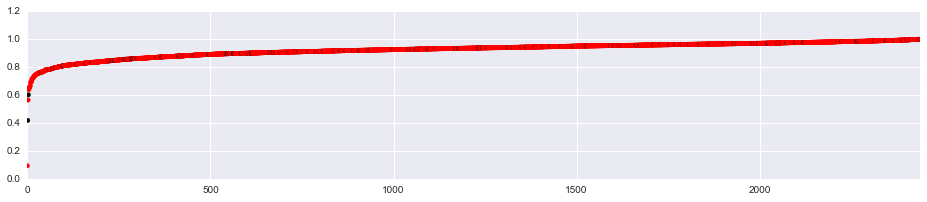

In [264]:
sis = y_pred_prob[:,1].argsort()
colormap = np.array(['k', 'r'])
plt.figure(figsize=(16, 3))
plt.scatter(range(len(y_pred_prob)),y_pred_prob[sis,1],color=colormap[list(y_test.iloc[sis])])
plt.gca().set_xlim([0,len(y_test)])
#plt.scatter(range(len(y_test)),y_test.iloc[sis],color=colormap[list(y_test.iloc[sis])])
print type(y_test)

print len(y_test),len(sis)
print max(y_test),min(y_test)
print y_test.shape,sis.shape,len(y_test[sis]),y_test[sis].shape

### Second attempt to evaluate the model graphically

This graph shows a boxplot of predicted probabilities broken down into 2 groups based on outcome. It is clear that 'successful' loans (loan_status_num ==1) have a higher distribution of predicted probabilites than 'unsuccessful' loans (loan_status_num == 0).

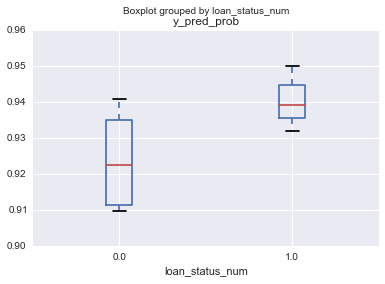

In [271]:
# merge these things into a single dataframe for plotting:
testdf=pd.concat([X_test,y_test,pd.DataFrame(y_pred_prob[:,1],columns=['y_pred_prob'])],axis=1)
testdf.boxplot(column='y_pred_prob',by='loan_status_num')


In [269]:
grouped = testdf.groupby('loan_status_num')
grouped.y_pred_prob.quantile([.25, .5, .75, 1])


loan_status_num      
0.0              0.25    0.911309
                 0.50    0.922406
                 0.75    0.934918
                 1.00    0.940833
1.0              0.25    0.935424
                 0.50    0.939085
                 0.75    0.944554
                 1.00    0.950023
dtype: float64

In [224]:
#plt.scatter(df.grade_num,df.loan_status_num,label='loan status')
#plt.plot(df2.grade_num,df2.loan_status_pred_num,color='red')
#plt.plot(X_test['grade_num'].sort_values(),y_pred_class,color='red')
#plt.setp(plt.gca(), xticklabels=gradenames, xticks = gradenums)
#plt.setp(plt.gca(), yticklabels=np.arange(0,1.2,.2), yticks = np.arange(0,1.2,.2))
#plt.setp(plt.gca(),title = 'Predicted loan status, test set')

## next...

In [157]:
print 'done'

done


In [182]:
print total_success_rate
print "percent of loans successful in y_test: {}/{} = {}".format(y_test[y_test == 1].count(), y_test.count(),
                                                       float(y_test[y_test == 1].count())/ y_test.count() )
print "logreg class prediction accuracy:" , metrics.accuracy_score(y_test, y_pred_class)
print "guess all successful accuracy: ", metrics.accuracy_score(y_test,[1]*len(y_test))

0.939801046047
percent of loans successful in y_test: 2302/2438 = 0.94421657096
logreg class prediction accuracy: 0.94421657096
guess all successful accuracy:  0.94421657096


In [159]:
grouped=df.groupby('grade')
probs=grouped.loan_status_num.sum()/grouped.loan_status_num.count()
print probs

grade
A    0.978221
B    0.960921
C    0.937593
D    0.914229
E    0.884514
F    0.804444
G    0.857143
Name: loan_status_num, dtype: float64


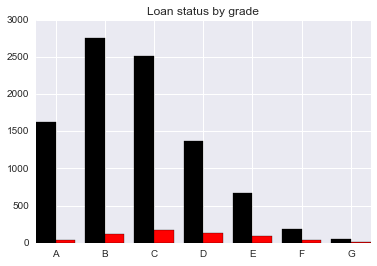

In [127]:
fig,ax = plt.subplots()
width=.4
xlocs=np.arange(0,7)
ax.bar(xlocs-width,grouped.loan_status_num.sum(),width,color='k')
ax.set_xticks(xlocs)
ax.set_xticklabels(sorted(df.grade.unique()))
ax.bar(
        xlocs,grouped.loan_status_num.apply(lambda item: (item == 0).sum()),width,
        color='r')
ax.set_title('Loan status by grade')

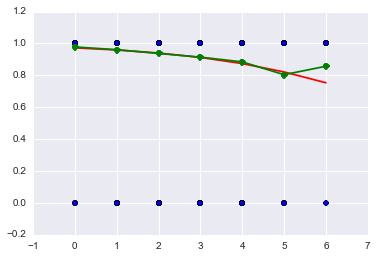

In [129]:
#df2['loan_status_pred_prob']=logreg.predict_proba(X)[:,1]
plt.scatter(df.grade_num,df.loan_status_num)
#plt.plot(df2.grade_num,df2.loan_status_pred_prob,color='red')
X_test_s=X_test.sort_values(by='grade_num').grade_num.reshape(-1,1)
plt.plot(X_test_s,logreg2.predict_proba(X_test_s)[:,1],color='red')

plt.plot(probs,'go-')